# TILD (NVT) -- N interacting atoms to (N-1) interacting atoms with 1 decoupled oscillator

### Introduction

This notebook is an example of the 'ProtocolTILDNVTPar' job in pyiron_contrib, which can be used to find the free energy difference $\Delta F$ between two systems of atoms $\mathrm{A}$ and $\mathrm{B}$ in a canonical ($NVT$) ensemble, given by the formula,

$\Delta F_\mathrm{A\rightarrow B}(N, V, T) = \int_0^1 \langle U_\mathrm{B}(\lambda) - U_\mathrm{A}(\lambda) \rangle_{(\lambda, N, V, T)} d\lambda$,

where $\lambda$ is the coupling parameter and $U$ is the potential energy of the system.

#### N interacting atoms to (N-1) interacting atoms with 1 decoupled oscillator

Here, we find the free energy difference between a system of $N$ atoms interating via a Lammps potential (as system $\mathrm{A}$) and a system of $(N-1)$ interacting atoms, with 1 atom decoupled from the rest, and behaving as a harmonic oscillator (as system $\mathrm{B}$).

We then use the result of this job to find the free energy change when the decoupled oscillator is turned to a vacancy.

### Pre-job setup

In [1]:
# imports

import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import physical_constants

from pyiron_atomistics import Project
import pyiron_contrib

KB = physical_constants['Boltzmann constant in eV/K'][0]
HBAR = physical_constants['Planck constant over 2 pi in eV s'][0]
ROOT_EV_PER_ANGSTROM_SQUARE_PER_AMU_IN_S = 9.82269385e13

In [2]:
# define project

pr = Project('tild_eam_to_vacancy')
pr.remove_jobs(recursive=True)

#### Inputs

In [4]:
# structure specific
element = 'Al'
crystal_structure = 'fcc'
supercell = 3
potential = '2008--Mendelev-M-I--Al--LAMMPS--ipr1'
a = 4.073603  # obtained from calc_md at 300K. 

# tild specific
temperature = 300.
n_lambdas = 3  # number of 'lambda'/integration points
lambda_bias = 0.65  # slightly right biased (lambdas close to system B)
n_steps = 100  # MD steps
thermalization_steps = 20  # number of steps to equilibrate the system for
sampling_steps = 5  # collect a 'sample' every 'sampling_period' steps 
convergence_steps = 50 # number of steps after which to check for convergence
fe_tol = 1e-3  # convergence criterion 0.1 meV 
oscillators_id_list = [0]  # !!! HAS to be a list, not an array or integer! !!!

# cluster specific
queue = 'cmti'
tild_cores = n_lambdas  # if running on the headnode, use 1! Otherwise, set to n_lambdas
tild_run_time = 14400  # in seconds

#### 0 K relaxation

In [5]:
pr_zero = pr.create_group('ionic_relaxation')

zero = pr_zero.create.job.Lammps('zero')
zero.structure = pr.create.structure.bulk(
    name=element, 
    crystalstructure=crystal_structure, 
    cubic=crystal_structure.lower() in ['fcc', 'bcc'],
    orthorhombic=crystal_structure.lower() in ['hcp']
).repeat(supercell)
n_atoms = len(zero.structure.positions)
zero.potential = potential
zero.calc_minimize(pressure=None)  # we keep the volume constant! (because we obtain the lattice constant from MD)
zero.run()

zero_k_energy = zero.output.energy_pot[-1]

The job zero was saved and received the ID: 983


/home/raynol025/pyiron/pyiron_atomistics/pyiron_atomistics/lammps/units.py:201: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity steps. Returning un-normalized quantity
  warnings.warn(message="Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity "
/home/raynol025/pyiron/pyiron_atomistics/pyiron_atomistics/lammps/units.py:201: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity indices. Returning un-normalized quantity
  warnings.warn(message="Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity "
/home/raynol025/pyiron/pyiron_atomistics/pyiron_atomistics/lammps/units.py:201: UserWarning: Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity velocities. Returning un-normalized quantity
  warnings.warn(message="Warning: Couldn't determine the LAMMPS to pyiron unit conversion type of quantity "
/home/raynol025/pyiro

In [6]:
zero = pr_zero.load(zero.name)

#### Spring constant for the decoupled oscillator job

In [7]:
# in case you want a calculated guess of the spring constant

# obtain a spring constant using 0K structure, by displacing a single atom
# a random spring constant can also be assumed, for example 1 or 5 eV/Ang^2

spring_folder = pr.create_group('spring_job')

# clear any existing spring_constant jobs
spring_folder.remove_jobs_silently(recursive=True)

spring_job = spring_folder.create_job(pr.job_type.Lammps, 'spring_job')
spring_job.structure = zero.get_structure()
spring_job.potential = potential

deviations = np.linspace(-0.5, 0.5, num=10)
restoring_forces = np.empty(deviations.shape)

spring_job.interactive_open()
for i, d in enumerate(deviations):
    spring_job.structure.positions[0, 0] = zero.get_structure().positions[0, 0] + d
    spring_job.calc_static()
    spring_job.run()
    restoring_forces[i] = spring_job.interactive_energy_pot_getter()
spring_job.interactive_close()

spring_constant = np.polyfit(deviations, restoring_forces, 2)[0]

print("A spring constant of {} eV/angstrom^2 was found".format(spring_constant))

The job spring_job was saved and received the ID: 984
A spring constant of 2.1878758023700002 eV/angstrom^2 was found


### TILDNVT job

#### Reference jobs

The 'ProtocolTILDNVTPar' job takes 'reference jobs' for the systems $\mathrm{A}$ and $\mathrm{B}$ as inputs. Here, we specify system $\mathrm{A}$ as a 'Lammps' job. System $\mathrm{B}$ is a 'DecoupledOscillators' job, which takes as input the spring constant we just obtained, and the index of the atom/s to treat as oscillators. 

The 'DecoupledOscillators' job itself takes as input a reference job, which in this notebook is a 'Lammps' job.

In [8]:
pr_tild = pr.create_group('tild_jobs')

# reference job a -> Lammps
ref_job_a = pr_tild.create_job(pr.job_type.Lammps, 'ref_job_a')
ref_job_a.structure = zero.get_structure().copy()
ref_job_a.potential = potential
ref_job_a.save()

# reference job b -> DecoupledOscillators
ref_job_for_b = pr_tild.create.job.Lammps('ref_job_for_b')
ref_job_for_b.structure = zero.get_structure().copy()
ref_job_for_b.potential = potential
ref_job_for_b.save()

# NOTE: ^^ the DecoupledOscillators job itself requires a reference job! 

ref_job_b = pr_tild.create.job.DecoupledOscillators('ref_job_b')
ref_job_b.input.ref_job_full_path = ref_job_for_b.path  # !!! job takes the path of the ref job! !!!
ref_job_b.input.structure = zero.get_structure().copy()
ref_job_b.input.oscillators_id_list = [0]  # atom index of the decoupled oscillator
ref_job_b.input.spring_constants_list = [spring_constant] * len(ref_job_b.input.oscillators_id_list)  # spring constant 
# ref_job_b.input.save_debug_data = False  # in case you want to see the individual harmonic/interacting components
ref_job_b.save()

The job ref_job_a was saved and received the ID: 985
The job ref_job_for_b was saved and received the ID: 986
The job ref_job_b was saved and received the ID: 987


987

#### Submit and run the job

In [9]:
tild_job = pr_tild.create_job(pr.job_type.ProtoTILDPar, 'tild_job')

# Tip: The documentation for the job can be accessed by running 'tild_job?' after the job has been defined!
    
tild_job.input.temperature = temperature
tild_job.input.ref_job_a_full_path = ref_job_a.path
tild_job.input.ref_job_b_full_path = ref_job_b.path
tild_job.input.n_lambdas = n_lambdas
tild_job.input.lambda_bias = lambda_bias
tild_job.input.n_steps = n_steps
tild_job.input.thermalization_steps = thermalization_steps
tild_job.input.sampling_steps = sampling_steps
tild_job.input.convergence_check_steps = convergence_steps
tild_job.input.fe_tol = fe_tol

# # in addition to these inputs, you can also modify the following inputs
# tild_job.input.time_step = 1.
# tild_job.input.temperature_damping_timescale = 100.
# tild_job.input.overheat_fraction = 2.
# tild_job.input.cutoff_factor = 0.5
# tild_job.input.use_reflection = False
# tild_job.input.zero_k_energy = 0. # incase you want to provide an energy offset to the HessianJob

# # set this only if you're running this on your local PC, and/or using MySQL as your DB manager
# tild_job.input.sleep_time = 0.1  

# cluster inputs
tild_job.server.cores = tild_cores
# tild_job.server.queue = queue
# tild_job.server.run_time = tild_run_time

# run_job
tild_job.run()

The job tild_job was saved and received the ID: 988
The job create_jobs_a_0 was saved and received the ID: 989
The job create_jobs_a_1 was saved and received the ID: 990
The job create_jobs_a_2 was saved and received the ID: 991
The job create_jobs_b_0__base was saved and received the ID: 992
The job create_jobs_b_0 was saved and received the ID: 993
The job create_jobs_b_1__base was saved and received the ID: 994
The job create_jobs_b_1 was saved and received the ID: 995
The job create_jobs_b_2__base was saved and received the ID: 996
The job create_jobs_b_2 was saved and received the ID: 997


/home/raynol025/pyiron/pyiron_base/pyiron_base/generic/parameters.py:282: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  warnings.warn(
/home/raynol025/pyiron/pyiron_base/pyiron_base/generic/parameters.py:282: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  warnings.warn(
/home/raynol025/pyiron/pyiron_base/pyiron_base/generic/parameters.py:282: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  warnings.warn(


Convergence not reached in 50 steps. Continuing run...


/home/raynol025/pyiron/pyiron_base/pyiron_base/generic/parameters.py:282: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  warnings.warn(
/home/raynol025/pyiron/pyiron_base/pyiron_base/generic/parameters.py:282: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  warnings.warn(
/home/raynol025/pyiron/pyiron_base/pyiron_base/generic/parameters.py:282: UserWarning: The input in GenericParameters changed, while the state of the job was already finished.
  warnings.warn(


Maximum steps (100) reached. Stopping run.


#### Load the job

In [10]:
if tild_job.status == 'finished':
    path = Project(str(pr.base_name) + '/' + str(pr_tild.base_name))
    tild_job = path.load(tild_job.job_name)  # here we load
    print('job loaded')
else:
    print('job still running')

job loaded


#### Collect output

In [11]:
total_steps = tild_job.output.total_steps[-1]
lambdas = tild_job.output.lambdas[-1]
temperature_mean = tild_job.output.temperature_mean[-1]
temperature_std = tild_job.output.temperature_std[-1]
integrands = tild_job.output.integrands[-1]
integrands_std = tild_job.output.integrands_std[-1]
integrands_n_samples = tild_job.output.integrands_n_samples[-1]
del_A_tild = tild_job.output.tild_free_energy_mean[-1]  # A, because this is the Helmholtz free energy
del_A_tild_std = tild_job.output.tild_free_energy_std[-1]
del_A_tild_se = tild_job.output.tild_free_energy_se[-1]
del_A_fep = tild_job.output.fep_free_energy_mean[-1]
del_A_fep_std = tild_job.output.fep_free_energy_std[-1]
del_A_fep_se = tild_job.output.fep_free_energy_se[-1]

# NOTE: The Helmholtz free energy from the FEP method returns a non-nan value, only if the initial and final
# systems are very close in potential energy to each other!

#### View output

In [12]:
# Check temperature of each lambda point

print('mean temperature: {} K'.format(np.mean(temperature_mean)))

mean temperature: 205.94699627954296 K


Lambdas:  [0.         0.53488372 1.        ]
Integrands plot: 


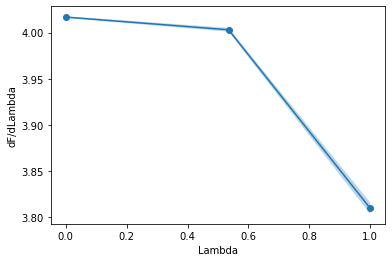

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Lambda', ylabel='dF/dLambda'>)

In [13]:
# Some inbuilt functions

print('Lambdas: ', tild_job.get_lambdas())
print('Integrands plot: ')
tild_job.plot_tild_integrands()

In [14]:
# Helmholtz free energy, A, between the interacting system, and the same system with a (quantum) harmonic 
# oscillator using TILD and FEP

print('del_A_tild: {} meV'.format(del_A_tild * 1e3))  # * 1e3 to convert it to meV
print('del_A_fep: {} meV'.format(del_A_fep * 1e3))

del_A_tild: 3978.2347139985573 meV
del_A_fep: 3957.364882664834 meV


In [15]:
# get the quantum harmonic free energy of the oscillator/s

def get_quantum_harmonic_free_energy(temperature=temperature, spring_constant=spring_constant):
    """
    Get the total free energy of a harmonic oscillator with this frequency and these atoms. Temperature is
        clipped at 1 micro-Kelvin.
    Returns:
        float/np.ndarray: The sum of the free energy of each atom.
    """
    temperature = np.clip(temperature, 1e-6, np.inf)
    beta = 1. / (KB * temperature)
    f = []
    masses = zero.get_structure().get_masses()
    for i, v in enumerate(ref_job_b.input.oscillators_id_list):
        hbar_omega = HBAR * np.sqrt(ref_job_b.input.spring_constants_list[i] / masses[v]) \
                     * ROOT_EV_PER_ANGSTROM_SQUARE_PER_AMU_IN_S
        f.append((3. / 2) * hbar_omega + ((3. / beta) * np.log(1 - np.exp(-beta * hbar_omega))))
    return np.array(f)

In [16]:
# total analytical free energy of the quantum harmonic oscialltor/s

A_qh_osc = get_quantum_harmonic_free_energy().sum()

In [17]:
# change in free energy while converting 1 of the interacting atoms to a vacancy

A_tild_vac = del_A_tild - A_qh_osc
A_fep_vac = del_A_fep - A_qh_osc
print('A_tild_vac: {} eV'.format(A_tild_vac))
print('A_fep_vac: {} eV'.format(A_fep_vac))

# NOTE: This is NOT the vacancy formation energy!

A_tild_vac: 4.002928761865417 eV
A_fep_vac: 3.9820589305316942 eV


In [18]:
# vacancy formation energy

A_tild = -3.4152485025674784  # ev/atom, from notebook 'protocol_tild_harmonic_to_eam_example.ipynb'
A_vac_form = A_tild + A_tild_vac
print('A_vac_form: {}'.format(A_vac_form))

A_vac_form: 0.5876802592979384
